In [1020]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import coo_matrix
from scipy.spatial.distance import cdist
from sklearn.decomposition import NMF, SparsePCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

#https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
import geopandas as gpd


In [241]:
cities = {}
categories = {}
with open('yelp_dataset/business.json') as f:
    for cnt, line in enumerate(f):
        d = json.loads(line)
        c = d['city']
        ca = d['categories']
        if ca:
            if ca in categories:
                categories[ca]+=1
            else:
                categories[ca]=1
        if c in cities:
            cities[c]+=1
        else:
            cities[c]=1

In [242]:
d

{'business_id': 'c1f_VAX1KIK8-JoVhjbYOw',
 'name': 'Oriental Relax',
 'address': '3735 S Las Vegas Blvd',
 'city': 'Las Vegas',
 'state': 'NV',
 'postal_code': '89109',
 'latitude': 36.1072672,
 'longitude': -115.1719204,
 'stars': 4.0,
 'review_count': 3,
 'is_open': 0,
 'attributes': {'BikeParking': 'False', 'RestaurantsPriceRange2': '1'},
 'categories': 'Massage, Beauty & Spas',
 'hours': {'Monday': '10:0-0:0',
  'Tuesday': '10:0-0:0',
  'Wednesday': '10:0-0:0',
  'Thursday': '10:0-0:0',
  'Friday': '10:0-0:0',
  'Saturday': '10:0-0:0',
  'Sunday': '10:0-0:0'}}

In [30]:
{k: v for k, v in sorted(cities.items(), key=lambda item: -item[1])}

{'Las Vegas': 29370,
 'Toronto': 18906,
 'Phoenix': 18766,
 'Charlotte': 9509,
 'Scottsdale': 8837,
 'Calgary': 7736,
 'Pittsburgh': 7017,
 'Montréal': 6449,
 'Mesa': 6080,
 'Henderson': 4892,
 'Tempe': 4550,
 'Chandler': 4309,
 'Cleveland': 3605,
 'Glendale': 3543,
 'Madison': 3494,
 'Gilbert': 3462,
 'Mississauga': 3112,
 'Peoria': 1919,
 'Markham': 1766,
 'North Las Vegas': 1548,
 'Champaign': 1262,
 'North York': 1205,
 'Surprise': 1148,
 'Scarborough': 1103,
 'Richmond Hill': 1026,
 'Brampton': 1002,
 'Concord': 990,
 'Vaughan': 919,
 'Goodyear': 855,
 'Etobicoke': 793,
 'Matthews': 749,
 'Avondale': 681,
 'Fort Mill': 627,
 'Huntersville': 625,
 'Lakewood': 519,
 'Gastonia': 480,
 'Cornelius': 474,
 'Mentor': 472,
 'Akron': 465,
 'Urbana': 411,
 'Cave Creek': 402,
 'Monroeville': 400,
 'North Olmsted': 396,
 'Thornhill': 396,
 'Laval': 394,
 'Westlake': 389,
 'Strongsville': 379,
 'Oakville': 362,
 'Middleton': 360,
 'Aurora': 356,
 'Cuyahoga Falls': 354,
 'Newmarket': 352,
 'Pin

In [31]:
{k: v for k, v in sorted(categories.items(), key=lambda item: -item[1])}

{'Restaurants, Pizza': 1042,
 'Nail Salons, Beauty & Spas': 1031,
 'Pizza, Restaurants': 993,
 'Beauty & Spas, Nail Salons': 947,
 'Food, Coffee & Tea': 888,
 'Mexican, Restaurants': 885,
 'Coffee & Tea, Food': 865,
 'Restaurants, Mexican': 853,
 'Chinese, Restaurants': 840,
 'Hair Salons, Beauty & Spas': 831,
 'Beauty & Spas, Hair Salons': 819,
 'Restaurants, Chinese': 789,
 'Automotive, Auto Repair': 585,
 'Auto Repair, Automotive': 534,
 'Food, Grocery': 492,
 'Grocery, Food': 491,
 'Restaurants, Italian': 474,
 'Italian, Restaurants': 446,
 'Banks & Credit Unions, Financial Services': 439,
 'Financial Services, Banks & Credit Unions': 401,
 'Ice Cream & Frozen Yogurt, Food': 395,
 'Food, Ice Cream & Frozen Yogurt': 386,
 'Beauty & Spas, Barbers': 374,
 'Barbers, Beauty & Spas': 371,
 'Real Estate, Apartments, Home Services': 340,
 'Apartments, Real Estate, Home Services': 338,
 'Apartments, Home Services, Real Estate': 335,
 'Real Estate, Home Services, Apartments': 328,
 'Home Ser

In [243]:
biz_set = {}
with open('yelp_dataset/business.json') as f:
    for cnt, line in enumerate(f):
        d = json.loads(line)
        c = d['city']
        ca = d['categories']
        lat = d['latitude']
        lon = d['longitude']
        if c in ('Toronto','Phoenix') and ca and ('Restaurants' in ca or 'Food' in ca):
            ca_fix = ':'.join(sorted(d['categories'].replace(' ','').split(',')))
            biz_set[d['business_id']] = (c, ca_fix, lat, lon)
            

In [244]:
print(f"number of businesses in both cities = {len(biz_set)}")

number of businesses in both cities = 15223


In [245]:
user = []
biz = []
stars = []
city = []
categories = []
lat = []
lon = []
with open('yelp_dataset/review.json') as f:
    for cnt, line in enumerate(f):
        d = json.loads(line)
        if d['business_id'] in biz_set:
            biz.append(d['business_id'])
            user.append(d['user_id'])
            stars.append(d['stars'])
            city.append(biz_set[d['business_id']][0])
            categories.append(biz_set[d['business_id']][1])
            lat.append(biz_set[d['business_id']][2])
            lon.append(biz_set[d['business_id']][3])

In [246]:
df = pd.DataFrame(list(zip(user,biz,stars,city,categories,lat,lon)),
                  columns=['user','biz','stars','city','categories','lat','lon'])

In [247]:
vc = df['user'].value_counts()
normal_users = vc.loc[(vc<500) & (vc>1)].index.tolist()
print(f"number of users = {len(normal_users)}")

number of users = 107770


In [248]:
df_filt = df.loc[df['user'].isin(normal_users)]
ncity = df_filt.groupby('user')['city'].nunique()
twocity = ncity.loc[ncity==2].index.tolist()

In [249]:
print(f"number of users with reviews in both cities = {len(twocity)}")

number of users with reviews in both cities = 1232


In [250]:
df_fin = df_filt.loc[df_filt['user'].isin(twocity)].copy()

In [1004]:
print(f"number of businesses reviewed by users from both cities = {df_fin['biz'].nunique()}")

number of businesses reviewed by users from both cities = 4738


In [251]:
df_fin.to_csv('toronto_phoenix_twocity_reviewers.csv')

build a simililarity strength between each location in toronto and phoenix
### mean cosine similarity between two groups

In [253]:
def index(df_fin, key):
    _ind = df_fin[key].unique()
    _ind = {k:v for k,v in zip(_ind,range(len(_ind)))}
    return np.vectorize(_ind.get)(df_fin[key].values)

In [972]:
def craycray_clust(df,tsne_perplexity=30,dbscan_eps=1,dbscan_min_samples=2):
    df_emb = TSNE(n_components=2,perplexity=tsne_perplexity).fit_transform(df[['lat','lon']].values)
    df['craycray_0']=df_emb[:,0]
    df['craycray_1']=df_emb[:,1]
    clustering = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit_predict(df[['craycray_0','craycray_1']].values)
    df['cluster']=clustering

In [254]:
df_fin['user_ind']=index(df_fin,'user')
df_fin['biz_ind']=index(df_fin,'biz')
df_fin.head()

,user,biz,stars,city,categories,lat,lon,user_ind,biz_ind
73,xsBjO0GTAvZK8i2A8_z20g,KUlm5OuKYJ6nGj0EUwcY9w,4.0,Toronto,Caterers:Ethiopian:EventPlanning&Services:Rest...,43.662039,-79.424830,0,0
100,3QFq-MJR6VcgpcgXNkc4gg,yHBhLawYmIthUPLbUXK5kw,4.0,Phoenix,LatinAmerican:Restaurants,33.508533,-112.029067,1,1
162,oc3u68ugJlAP__025Ji2fw,RrXlDMjW30v2KatCxOobdQ,3.0,Phoenix,Food:Grocery:HealthMarkets:OrganicStores:Speci...,33.584228,-111.978752,2,2
267,S5DGX7S0HsBw01a7R1ZAEg,50NTSGbZ3pN5643_K1IReA,3.0,Phoenix,Food:Mexican:Restaurants,33.569407,-112.074131,3,3
402,0tZaT5n7kjXRk_JQACRHtQ,8Zqh2jwtncA3N4fWEMTvZQ,3.0,Phoenix,Breakfast&Brunch:Gluten-Free:Pizza:Restaurants...,33.576307,-112.065576,4,4


In [255]:
X = coo_matrix((df_fin['stars'].values,(df_fin['biz_ind'].values,df_fin['user_ind'].values)))

In [1038]:
S = cosine_similarity(X)

In [1074]:
df_biz = df_fin[['biz_ind','categories','city','lat','lon']].drop_duplicates().sort_values('biz_ind')

In [1075]:
phx = df_biz.loc[df_biz['city']=='Phoenix'].copy()
craycray_clust(phx,tsne_perplexity=50,dbscan_eps=3)

,OBJECTID,NAME,ACRES,URL,INSERT_DAT,UPDATE_DAT,ANID,geometry
0,13,South Mountain,25481.86,https://phoenix.gov/villages/South-Mountain,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2443,"POLYGON ((683945.250 859952.062, 683530.875 86..."
1,14,Laveen,19554.84,https://phoenix.gov/villages/Laveen,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2444,"POLYGON ((638589.250 843376.000, 629247.625 83..."
3,1,Rio Vista,26534.10,https://phoenix.gov/villages/Rio-Vista,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2431,"POLYGON ((623261.118 1076271.904, 628563.218 1..."
4,2,North Gateway,28615.60,https://phoenix.gov/villages/North-Gateway,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2432,"POLYGON ((630914.697 1033648.600, 630840.682 1..."
5,3,Desert View,43398.25,https://phoenix.gov/villages/Desert-View,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2433,"POLYGON ((649569.375 1018313.750, 649568.749 1..."
6,4,Deer Valley,36221.18,https://phoenix.gov/villages/Deer-Valley,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2434,"POLYGON ((649639.188 991718.313, 654908.063 99..."
7,5,Paradise Valley,27522.47,https://phoenix.gov/villages/Paradise-Valley,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2435,"POLYGON ((675378.063 968573.812, 675766.813 96..."
8,6,North Mountain,22201.76,https://phoenix.gov/villages/North-Mountain,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2436,"POLYGON ((659983.813 959089.500, 659990.125 95..."
9,7,Camelback East,23227.85,https://phoenix.gov/villages/Camelback-East,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2437,"POLYGON ((675972.563 928858.750, 676035.439 92..."
10,8,Alhambra,12315.42,https://phoenix.gov/villages/Alhambra,2016-05-05T04:10:41.000Z,2017-06-26T13:26:29.000Z,2438,"POLYGON ((654743.250 928667.000, 654745.375 92..."


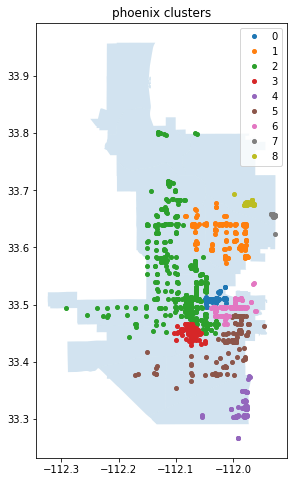

In [1139]:
fig, ax = plt.subplots(figsize=(10,8))

#http://mapping-phoenix.opendata.arcgis.com/
phx_map = gpd.read_file('phoenix_map/Villages.shp').to_crs('EPSG:4326')

phx_map.plot(ax=ax,alpha=0.2)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in phx.groupby('cluster'):
    ax.plot(group['lon'], group['lat'], marker='o', linestyle='', ms=4, label=name)
plt.title('phoenix clusters')
plt.legend()
plt.show()


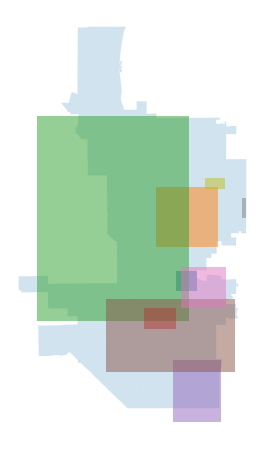

In [1195]:
fig, ax = plt.subplots(figsize=(10,8))

phx_map.plot(ax=ax,alpha=0.2)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in phx.groupby('cluster'):
    points_x = [group['lon'].min(), group['lon'].min(), group['lon'].max(), group['lon'].max()]
    points_y = [group['lat'].min(), group['lat'].max(), group['lat'].max(), group['lat'].min()]
    ax.fill(points_x, points_y,label=name,alpha=0.5)
fig.patch.set_visible(False)
ax.axis('off')
# ax.set_ylim(ax.get_ylim()[1], ax.get_ylim()[0])
# ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])

plt.savefig("phx.svg", format="svg")
plt.show()


In [1077]:
tor = df_biz.loc[df_biz['city']=='Toronto'].copy()
craycray_clust(tor,tsne_perplexity=50,dbscan_eps=5)

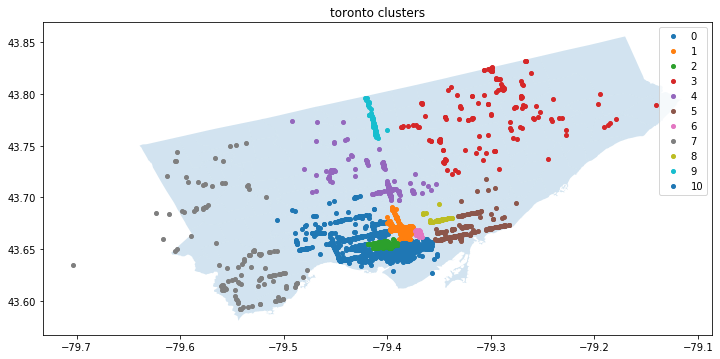

In [1141]:
fig, ax = plt.subplots(figsize=(12,10))

# https://open.toronto.ca/dataset/neighbourhoods/
tor_map = gpd.read_file('toronto_map/Neighbourhoods.shp')

tor_map.plot(ax=ax,alpha=0.2)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in tor.groupby('cluster'):
    ax.plot(group['lon'], group['lat'], marker='o', linestyle='', ms=4, label=name)
plt.title('toronto clusters')
plt.legend()
plt.show()

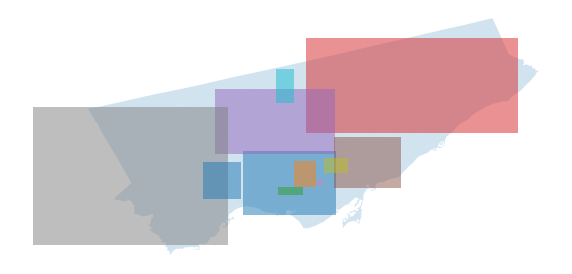

In [1197]:
fig, ax = plt.subplots(figsize=(10,8))

tor_map.plot(ax=ax,alpha=0.2)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in tor.groupby('cluster'):
    points_x = [group['lon'].min(), group['lon'].min(), group['lon'].max(), group['lon'].max()]
    points_y = [group['lat'].min(), group['lat'].max(), group['lat'].max(), group['lat'].min()]
    ax.fill(points_x, points_y,label=name,alpha=0.5)
fig.patch.set_visible(False)
ax.axis('off')

plt.savefig("tor.svg", format="svg")
plt.show()


In [1169]:
t_clusts = []
p_clusts = []
sims = []

for name_t, group_t in tor.groupby('cluster'):
    for name_p, group_p in phx.groupby('cluster'):
        sim_sum = 0
        sim_N = 0
        for t_b in group_t['biz_ind']:
            for p_b in group_p['biz_ind']:
                sim_sum += S[t_b,p_b]
                sim_N += 1
        t_clusts.append(name_t)
        p_clusts.append(name_p)
        sims.append(sim_sum/sim_N)
df_cl = pd.DataFrame(list(zip(t_clusts,p_clusts,sims)),columns=['t_clust','p_clust','sim']) 

In [1170]:
df_cl_t = tor.groupby('cluster')['lat','lon'].mean().copy().reset_index()
df_cl_t['x']=df_cl_t['lon']
df_cl_t['y']=df_cl_t['lat']

In [1171]:
p_i_clusts = []
p_j_clusts = []
p_i_x = []
p_i_y = []
p_dists = []

for name_i, group_i in phx.groupby('cluster'):
    for name_j, group_j in phx.groupby('cluster'):
        inds = ['lon','lat']
        dist = cdist(group_i[inds].values,group_j[inds].values).mean()
        p_i_clusts.append(name_i)
        p_j_clusts.append(name_j)
        p_i_x.append(group_i['lon'].mean())
        p_i_y.append(group_i['lat'].mean())
        p_dists.append(dist)
df_cl_p = pd.DataFrame(list(zip(p_i_clusts,p_j_clusts,p_dists,p_i_x,p_i_y)),
                       columns=['p_i_clust','p_j_clust','dist','x','y']) 


In [1172]:
df_cl_t['source'] = 'tor.'+df_cl_t['cluster'].apply(str)
df_cl['source'] = 'phx.'+df_cl['p_clust'].apply(str)
df_cl['target'] = 'tor.'+df_cl['t_clust'].apply(str)
df_cl_p['source'] = 'phx.'+df_cl_p['p_i_clust'].apply(str)
df_cl_p['target'] = 'phx.'+df_cl_p['p_j_clust'].apply(str)

df_cl['type'] = 1
df_cl_t['type'] = 0
df_cl_p['type'] = 0

df_cl['mobile'] = 0
df_cl_t['mobile'] = 0
df_cl_p['mobile'] = 1

length_scale = ((df_cl_t['x'].max()-df_cl_t['x'].min()) + (df_cl_t['y'].max()-df_cl_t['y'].min()))/2
df_cl_t['x'] = (df_cl_t['x']-df_cl_t['x'].min())/length_scale
df_cl_t['y'] = (df_cl_t['y']-df_cl_t['y'].min())/length_scale

df_cl_p['x'] = (df_cl_p['x']-df_cl_p['x'].min())/length_scale
df_cl_p['y'] = (df_cl_p['y']-df_cl_p['y'].min())/length_scale


df_cl_p['dist'] = df_cl_p['dist']/length_scale


In [1173]:
df_cl_combo = pd.concat([df_cl_t,df_cl_p],axis=0,sort=False)
df_cl_combo = df_cl_combo.fillna(-1)

unique_ips = df_cl_combo[['source','x','y','mobile']].drop_duplicates().set_index('source')

df_cl_combo = pd.concat([df_cl,df_cl_p],axis=0,sort=False)
df_cl_combo = df_cl_combo.fillna(-1)

links_list = list(df_cl_combo.apply(lambda row: {"source": unique_ips.index.get_loc(row['source']), 
                                                      "target": unique_ips.index.get_loc(row['target']), 
                                                      "dist": row['dist'], 
                                                      "sim": row['sim'], 
                                                      "type": row['type'], 
                                                      "mobile": row['mobile']}, axis=1))
print('links made')
nodes_list = []
for ip in unique_ips.index:
    nodes_list.append({"name":ip, 
                       "group": unique_ips.index.get_loc(ip), 
                       "xo": unique_ips.loc[ip,'x'],
                       "yo": unique_ips.loc[ip,'y'],
                       "mobile": float(unique_ips.loc[ip,'mobile']),
                      })
print('nodes made')
json_prep = {"nodes":nodes_list, "links":links_list}
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

with open('city_export.json','w') as f:
    f.write(json_dump)
    
#https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.PolynomialTransform

links made
nodes made


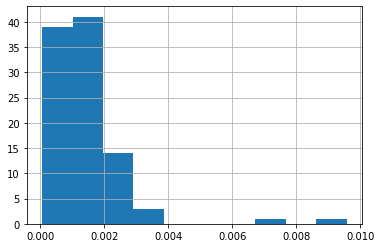

In [1200]:
df_cl['sim'].hist()

### now lets try a high-falutin dimensionality reduction based technique for defining similar businesses

In [955]:
model = NMF(n_components=50, init='random', random_state=0)
# model = PCA(n_components=100)

In [956]:
W = model.fit_transform(X.toarray())
W.shape

(4738, 50)

In [957]:
H = model.components_
H.shape

(50, 1232)

In [958]:
df_biz = df_fin[['biz_ind','categories','city','lat','lon']].drop_duplicates().sort_values('biz_ind')
for i in range(W.shape[1]):
    df_biz[f'dim_{i}']=W[:,i]

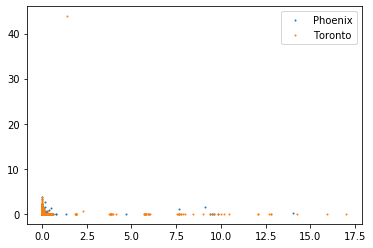

In [959]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df_biz.groupby('city'):
    ax.plot(group['dim_0'], group['dim_1'], marker='o', linestyle='', ms=1, label=name)
ax.legend()

plt.show()

The dimensionality reduction on its own doesn't look too informative.  further breaking it down with a tsne

In [981]:
tsne = TSNE(n_components=2,perplexity=100).fit_transform(W)

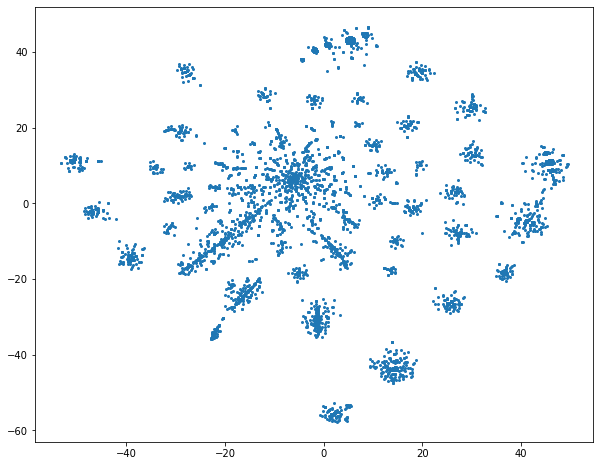

In [989]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(tsne[:,0],tsne[:,1],marker='o', linestyle='', ms=2)

Are these clusters meaningful?

### check if categories are correlated with clusters

In [983]:
for i in range(tsne.shape[1]):
    df_biz[f'tsne_{i}']=tsne[:,i]

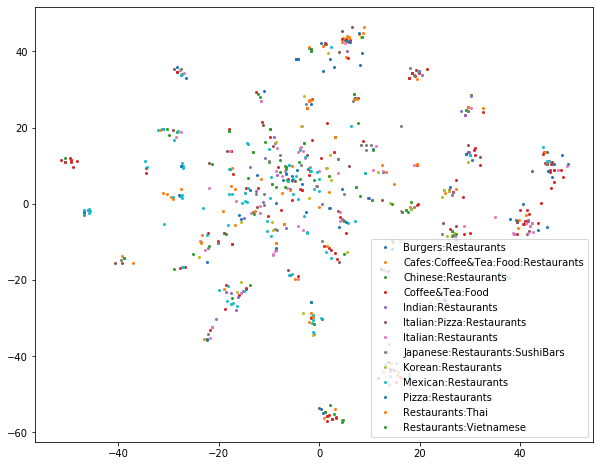

In [988]:
fig, ax = plt.subplots(figsize=(10,8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df_biz.groupby('categories'):
    if len(group)>30:
        ax.plot(group['tsne_0'], group['tsne_1'], marker='o', linestyle='', ms=2, label=name)
ax.legend()

plt.show()

Doesn't look good.  let's see if they correlate with location.

### generate lat/lon based clusters, and see if they correlate with the embedding+tsne clusters

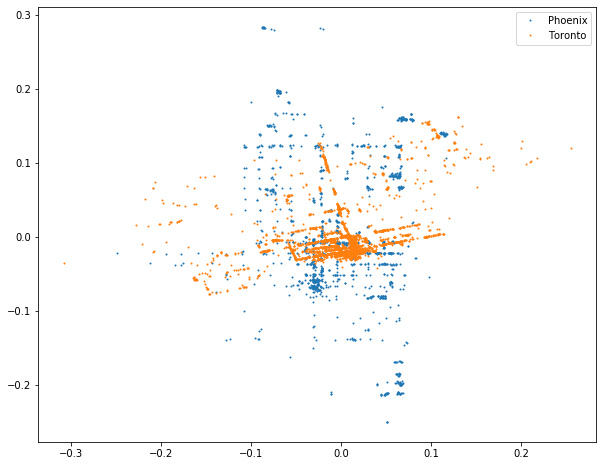

In [991]:
fig, ax = plt.subplots(figsize=(10,8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df_biz.groupby('city'):
    ax.plot(group['lon']-group['lon'].mean(), group['lat']-group['lat'].mean(), marker='o', linestyle='', ms=1, label=name)
ax.legend()
plt.show()

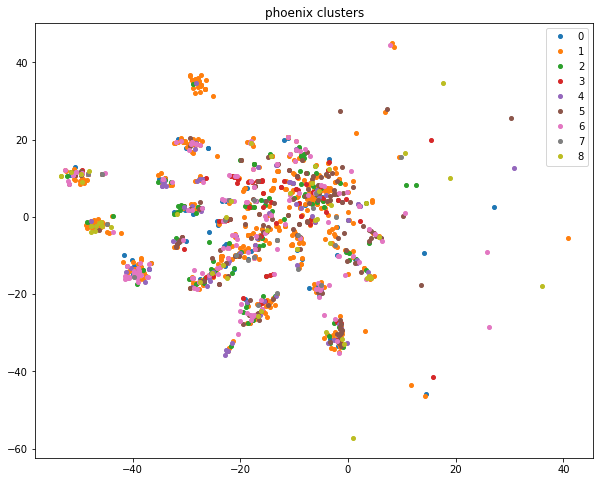

In [1000]:
fig, ax = plt.subplots(figsize=(10,8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in phx.groupby('cluster'):
    ax.plot(group['tsne_0'], group['tsne_1'], marker='o', linestyle='', ms=4, label=name)
plt.title('phoenix clusters')
plt.legend()
plt.show()

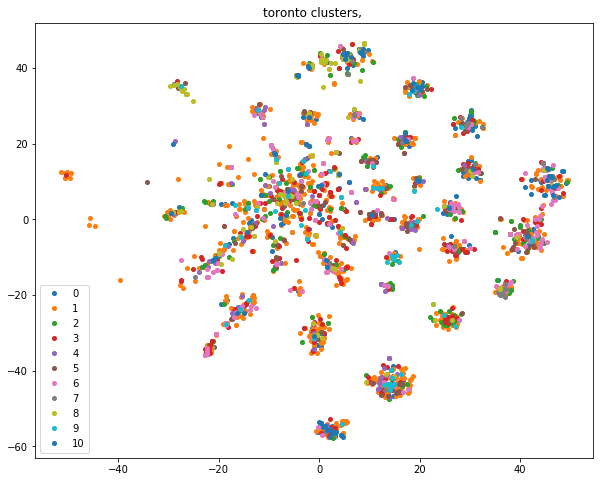

In [1003]:
fig, ax = plt.subplots(figsize=(10,8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in tor.groupby('cluster'):
    ax.plot(group['tsne_0'], group['tsne_1'], marker='o', linestyle='', ms=4, label=name)
plt.title('toronto clusters, ')
plt.legend()
plt.show()

OK, but it doesn't look like this embedding is so great.  

## Trying a simpler clustering

In [1032]:
cl = AgglomerativeClustering(n_clusters=10).fit_predict(X.toarray())

In [1033]:
np.unique(cl,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 243,  175,   95, 3376,   65,  255,   83,  165,  219,   62]))

In [1034]:
df_biz['agg_cl']=cl

In [1035]:
phx = df_biz.loc[df_biz['city']=='Phoenix'].copy()

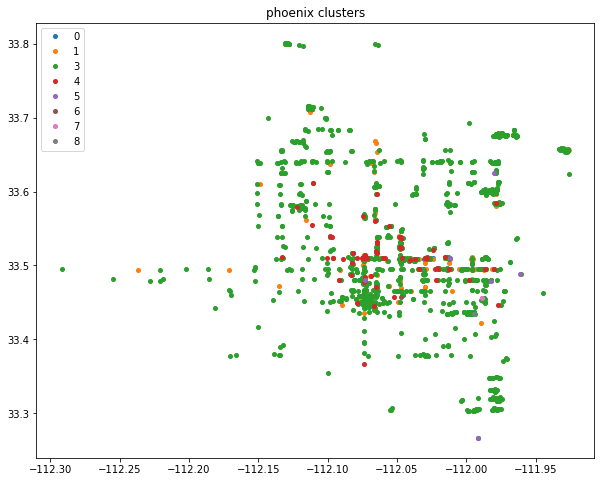

In [1036]:
fig, ax = plt.subplots(figsize=(10,8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in phx.groupby('agg_cl'):
    ax.plot(group['lon'], group['lat'], marker='o', linestyle='', ms=4, label=name)
plt.title('phoenix clusters')
plt.legend()
plt.show()

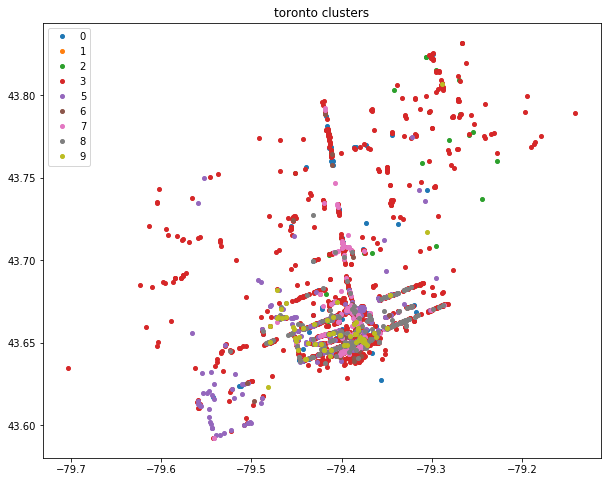

In [1037]:
tor = df_biz.loc[df_biz['city']=='Toronto'].copy()
fig, ax = plt.subplots(figsize=(10,8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in tor.groupby('agg_cl'):
    ax.plot(group['lon'], group['lat'], marker='o', linestyle='', ms=4, label=name)
plt.title('toronto clusters')
plt.legend()
plt.show()

### complicated cluster method

In [930]:
t_clusts = []
p_clusts = []
dists = []

for name_t, group_t in tor.groupby('cluster'):
    for name_p, group_p in phx.groupby('cluster'):
        inds = [f'dim_{i}' for i in range(10)]
        dist = cdist(group_t[inds].values,group_p[inds].values).mean()
        t_clusts.append(name_t)
        p_clusts.append(name_p)
        dists.append(dist)
df_cl = pd.DataFrame(list(zip(t_clusts,p_clusts,dists)),columns=['t_clust','p_clust','avg_dist']) 

In [931]:
t_i_clusts = []
t_i_x = []
t_i_y = []
t_j_clusts = []
t_dists = []

for name_i, group_i in tor.groupby('cluster'):
    for name_j, group_j in tor.groupby('cluster'):
        inds = ['lon','lat']
        dist = cdist(group_i[inds].values,group_j[inds].values).mean()
        t_i_x.append(group_i['lon'].mean())
        t_i_y.append(group_i['lat'].mean())
        t_i_clusts.append(name_i)
        t_j_clusts.append(name_j)
        t_dists.append(dist)
df_cl_t = pd.DataFrame(list(zip(t_i_clusts,t_j_clusts,t_dists,t_i_x,t_i_y)),
                       columns=['t_i_clust','t_j_clust','avg_dist','x','y']) 


In [932]:
p_i_clusts = []
p_j_clusts = []
p_i_x = []
p_i_y = []
p_dists = []

for name_i, group_i in phx.groupby('cluster'):
    for name_j, group_j in phx.groupby('cluster'):
        inds = ['lon','lat']
#         dist = cdist(group_i[inds].values,group_j[inds].values).mean()
        ilon = (group_i['lon'].max()+group_i['lon'].min())/2
        jlon = (group_j['lon'].max()+group_j['lon'].min())/2
        ilat = (group_i['lat'].max()+group_i['lat'].min())/2
        jlat = (group_j['lat'].max()+group_j['lat'].min())/2
        dist = np.sqrt((ilon-jlon)**2 + (ilat-jlat)**2 )
        p_i_x.append(group_i['lon'].mean())
        p_i_y.append(group_i['lat'].mean())
        p_i_clusts.append(name_i)
        p_j_clusts.append(name_j)
        p_dists.append(dist)
df_cl_p = pd.DataFrame(list(zip(p_i_clusts,p_j_clusts,p_dists,p_i_x,p_i_y)),
                       columns=['p_i_clust','p_j_clust','avg_dist','x','y']) 


In [933]:
df_cl_t['source'] = 'tor.'+df_cl_t['t_i_clust'].apply(str)
df_cl_t['target'] = 'tor.'+df_cl_t['t_j_clust'].apply(str)
df_cl['source'] = 'phx.'+df_cl['p_clust'].apply(str)
df_cl['target'] = 'tor.'+df_cl['t_clust'].apply(str)
df_cl_p['source'] = 'phx.'+df_cl_p['p_i_clust'].apply(str)
df_cl_p['target'] = 'phx.'+df_cl_p['p_j_clust'].apply(str)

df_cl['type'] = 1
df_cl_t['type'] = 0
df_cl_p['type'] = 0

df_cl['mobile'] = 0
df_cl_t['mobile'] = 0
df_cl_p['mobile'] = 1

length_scale = ((df_cl_t['x'].max()-df_cl_t['x'].min()) + (df_cl_t['y'].max()-df_cl_t['y'].min()))/2
df_cl_t['x'] = (df_cl_t['x']-df_cl_t['x'].min())/(df_cl_t['x'].max()-df_cl_t['x'].min())
df_cl_t['y'] = (df_cl_t['y']-df_cl_t['y'].min())/(df_cl_t['y'].max()-df_cl_t['y'].min())

df_cl_p['x'] = (df_cl_p['x']-df_cl_p['x'].min())/(df_cl_p['x'].max()-df_cl_p['x'].min())
df_cl_p['y'] = (df_cl_p['y']-df_cl_p['y'].min())/(df_cl_p['y'].max()-df_cl_p['y'].min())

df_cl_p['avg_dist'] = df_cl_p['avg_dist']/length_scale
df_cl['avg_dist'] = (df_cl['avg_dist'] - df_cl['avg_dist'].min())/(df_cl['avg_dist'].max() - df_cl['avg_dist'].min())

In [935]:
df_cl_combo = pd.concat([df_cl_t,df_cl_p],axis=0,sort=False)

#http://www.austintaylor.io/d3/python/pandas/2016/02/01/create-d3-chart-python-force-directed/

unique_ips = df_cl_combo[['source','x','y','mobile']].drop_duplicates().set_index('source')

df_cl_combo = pd.concat([df_cl,df_cl_p],axis=0,sort=False)

temp_links_list = list(df_cl_combo.apply(lambda row: {"source": row['source'], 
                                                      "target": row['target'], 
                                                      "dist": row['avg_dist'], 
                                                      "type": row['type'], 
                                                      "mobile": row['mobile']}, axis=1))
links_list = []
for link in temp_links_list:
    record = {"dist":link['dist'], 
              "source":unique_ips.index.get_loc(link['source']),
              "target": unique_ips.index.get_loc(link['target']),
              "type": link['type'],
              "mobile": link['mobile']
             }
    if link['dist']!=1:
        links_list.append(record)
    
nodes_list = []
for ip in unique_ips.index:
    nodes_list.append({"name":ip, 
                       "group": unique_ips.index.get_loc(ip), 
                       "xo": unique_ips.loc[ip,'x'],
                       "yo": unique_ips.loc[ip,'y'],
                       "mobile": float(unique_ips.loc[ip,'mobile']),
                      })
    
json_prep = {"nodes":nodes_list, "links":links_list}
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

with open('city_export5.json','w') as f:
    f.write(json_dump)